In [2]:
#!pip3 install torch torchvision
!pip3 install albumentations #for image augmentation 

     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d7f46cd1d541e6140c3a7fde6b3eb3687745f092c468a6f890305eed632e16b1
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import os
import sys
import albumentations as aug
from model import Unet
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time
from tqdm import tqdm_notebook
import matplotlib.image as mpimg

In [0]:
##location for train and val data
image_dir = 'dataset/Image/'
mask_dir = 'dataset/Mask/'
train_dir = image_dir + 'train/'
val_dir = image_dir + 'val/'
train_files = sorted(os.listdir(train_dir))
val_files = sorted(os.listdir(val_dir))

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 8))
    for i, (name, image) in enumerate(images.items()):
        if image.shape[0] == 3:
            image = image.numpy()
            image = image.transpose((1,2,0))
        elif image.shape[0] == 1:
            image = image.numpy()
            image = image.reshape(image.shape[1],image.shape[2])
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
##Daloader for our dataset
class FarmDataset(Dataset):
    def __init__(self,data,data_dir,mask_dir,transform = None):
        self.data = data
        self.data_dir = data_dir
        self.mask_dir = mask_dir
        self.transform = transform
               
    def __len__(self):
        return (len(self.data))
    
      
    def __getitem__(self,idx):
        image = cv2.imread(self.data_dir+self.data[idx])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_dir+self.data[idx], cv2.IMREAD_GRAYSCALE)
        mask[mask!=0] = 1
        if self.transform != None:
            for augment in [*self.transform]:
                augmented = augment(image=image,mask=mask)
                image = augmented ['image']
                mask = augmented ['mask']
        image = image/255
        if(len(mask.shape) == 2):
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2,0,1))
        
        return torch.from_numpy(image).float(),torch.from_numpy(mask).float()

In [0]:
#Augmentations applied
train_transform = [aug.RandomRotate90(p=0.5),
                   aug.Flip(p=0.5),aug.Resize(384,384),
                   aug.IAAAdditiveGaussianNoise(p=0.2),
                   aug.IAAPerspective(p=0.5),
                   aug.OneOf(
                       [aug.CLAHE(p=1),aug.RandomBrightness(p=1),
                        aug.RandomGamma(p=1)],p=0.9),
                  aug.OneOf(
                      [aug.RandomContrast(p=1),
                       aug.HueSaturationValue(p=1),],p=0.9)
                  ]

In [0]:
train_dataset = FarmDataset(train_files, train_dir,mask_dir,transform=train_transform)

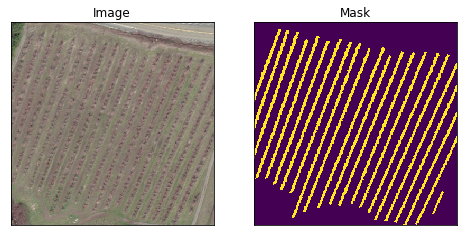

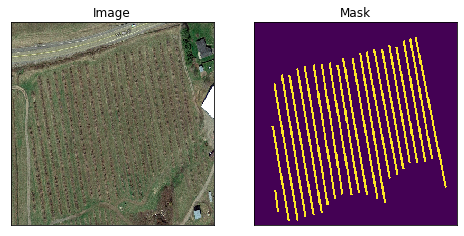

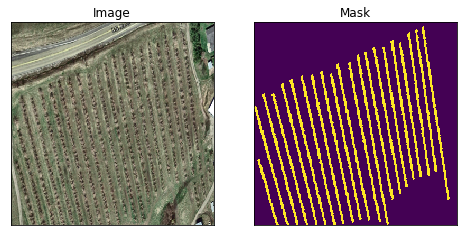

In [0]:
#visualizing some training data with augmentations implied
for i in range(3):
    image, mask = train_dataset[7]
    visualize(image=image, mask=mask)

In [0]:
def train_epoch(model, train_loader, criterion,optimizer):
    model.train()
    model.to(device)
    running_loss = 0.0
    dice_coef = 0.0
    #start_time = time.time()
    for ip,op in tqdm_notebook(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = ip.to(device)
        target = op.to(device) # all data & model on same device
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    #end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss)#, 'Time: ',end_time - start_time, 's')
    return running_loss

In [0]:
def eval_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        running_loss = 0.0
        dice_coef = 0.0
        #start_time = time.time()
        for ip,op in tqdm_notebook(test_loader):   
            data = ip.to(device)
            target = op.to(device)
            outputs = model(data)
            loss = criterion(outputs, target).detach()
            running_loss += loss.item()
        #end_time = time.time()
        running_loss /= len(test_loader)
        print('Testing Loss: ', running_loss)#, 'Time: ',end_time - start_time, 's')
        return running_loss

In [0]:
v_transform = [aug.Resize(384,384)]
val_dataset = FarmDataset(val_files, val_dir, mask_dir,transform=v_transform)

In [0]:
batch_size = 8
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True)
val_loader = DataLoader(val_dataset,
                       batch_size = batch_size,shuffle=False)

In [0]:
cuda = torch.cuda.is_available()
mymodel = Unet(3,1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mymodel.parameters(),lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer,5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.2,patience=5)
device = torch.device("cuda" if cuda else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


In [0]:
##Uncomment these lines to train the model
# epoch = 0
# n_epochs = 40
# Train_loss = []
# Val_loss = []
# for i in range(epoch,n_epochs):
#     print("Epochs : ",(i+1),"/",(n_epochs))
#     train_loss = train_epoch(mymodel, train_loader, criterion,optimizer)
#     val_loss = eval_model(mymodel, val_loader,criterion)
#     Train_loss.append(train_loss)
#     Val_loss.append(val_loss)
#     print("--"*20)
#     scheduler.step(val_loss)

Epochs :  1 / 40



Training Loss:  0.6145234153820918



Testing Loss:  0.7264177997907003
----------------------------------------
Epochs :  2 / 40



Training Loss:  0.5415231104080493



Testing Loss:  0.5960285067558289
----------------------------------------
Epochs :  3 / 40



Training Loss:  0.5155015014685117



Testing Loss:  0.44797680775324505
----------------------------------------
Epochs :  4 / 40



Training Loss:  0.5069668682721945



Testing Loss:  0.4143869678179423
----------------------------------------
Epochs :  5 / 40



Training Loss:  0.4892225769849924



Testing Loss:  0.3967207372188568
----------------------------------------
Epochs :  6 / 40



Training Loss:  0.47845630003855777



Testing Loss:  0.43499869108200073
----------------------------------------
Epochs :  7 / 40



Training Loss:  0.4689388068822714



Testing Loss:  0.394039382537206
----------------------------------------
Epochs :  8 / 40



Training Loss:  0.4665936300387749



Testing Loss:  0.36806108554204303
----------------------------------------
Epochs :  9 / 40



Training Loss:  0.46299066222631013



Testing Loss:  0.41516945759455365
----------------------------------------
Epochs :  10 / 40



Training Loss:  0.4528845502780034



Testing Loss:  0.36282971501350403
----------------------------------------
Epochs :  11 / 40



Training Loss:  0.463128931247271



Testing Loss:  0.35783617695172626
----------------------------------------
Epochs :  12 / 40



Training Loss:  0.45309773316750157



Testing Loss:  0.36014188329378766
----------------------------------------
Epochs :  13 / 40



Training Loss:  0.43590014485212475



Testing Loss:  0.3555827736854553
----------------------------------------
Epochs :  14 / 40



Training Loss:  0.4395403747375195



Testing Loss:  0.36767496665318805
----------------------------------------
Epochs :  15 / 40



Training Loss:  0.4390807495667384



Testing Loss:  0.35493133465449017
----------------------------------------
Epochs :  16 / 40



Training Loss:  0.4309895015679873



Testing Loss:  0.36199302474657696
----------------------------------------
Epochs :  17 / 40



Training Loss:  0.4371003554417537



Testing Loss:  0.35277801752090454
----------------------------------------
Epochs :  18 / 40



Training Loss:  0.4262561316673572



Testing Loss:  0.33674879868825275
----------------------------------------
Epochs :  19 / 40



Training Loss:  0.42890556500508237



Testing Loss:  0.34759841362635296
----------------------------------------
Epochs :  20 / 40



Training Loss:  0.421150063092892



Testing Loss:  0.3443651994069417
----------------------------------------
Epochs :  21 / 40



Training Loss:  0.4271032099540417



Testing Loss:  0.35409221053123474
----------------------------------------
Epochs :  22 / 40



Training Loss:  0.4194348339851086



Testing Loss:  0.3340469499429067
----------------------------------------
Epochs :  23 / 40



Training Loss:  0.4207716996853168



Testing Loss:  0.3353898227214813
----------------------------------------
Epochs :  24 / 40



Training Loss:  0.415185985656885



Testing Loss:  0.3618640899658203
----------------------------------------
Epochs :  25 / 40



Training Loss:  0.42710896867972153



Testing Loss:  0.33921756347020465
----------------------------------------
Epochs :  26 / 40



Training Loss:  0.41960440002954924



Testing Loss:  0.34658469756444293
----------------------------------------
Epochs :  27 / 40



Training Loss:  0.4151414128450247



Testing Loss:  0.3436692456404368
----------------------------------------
Epochs :  28 / 40



Training Loss:  0.42679399939683765



Testing Loss:  0.33131473263104755
----------------------------------------
Epochs :  29 / 40



Training Loss:  0.40589638168995196



Testing Loss:  0.35483211278915405
----------------------------------------
Epochs :  30 / 40



Training Loss:  0.4246265704815204



Testing Loss:  0.32473302880922955
----------------------------------------
Epochs :  31 / 40



Training Loss:  0.3977341537292187



Testing Loss:  0.3231150607268016
----------------------------------------
Epochs :  32 / 40



Training Loss:  0.39419618936685413



Testing Loss:  0.3213350772857666
----------------------------------------
Epochs :  33 / 40



Training Loss:  0.3954789638519287



Testing Loss:  0.3170577784379323
----------------------------------------
Epochs :  34 / 40



Training Loss:  0.4005423325758714



Testing Loss:  0.31899766127268475
----------------------------------------
Epochs :  35 / 40



Training Loss:  0.38684515998913693



Testing Loss:  0.3405941128730774
----------------------------------------
Epochs :  36 / 40



Training Loss:  0.39123836159706116



Testing Loss:  0.32002902030944824
----------------------------------------
Epochs :  37 / 40



Training Loss:  0.40244310865035426



Testing Loss:  0.315175066391627
----------------------------------------
Epochs :  38 / 40



Training Loss:  0.38593798646560085



Testing Loss:  0.3103984594345093
----------------------------------------
Epochs :  39 / 40



Training Loss:  0.3858054349055657



Testing Loss:  0.32611967126528424
----------------------------------------
Epochs :  40 / 40



Training Loss:  0.3908185339890994



Testing Loss:  0.3095495005448659
----------------------------------------


In [0]:
# save_mdl = "model.pt"
# torch.save(mymodel.state_dict(),save_mdl)

In [0]:
mymodel.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

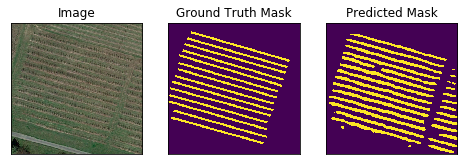

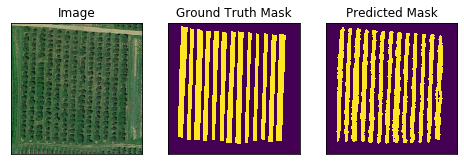

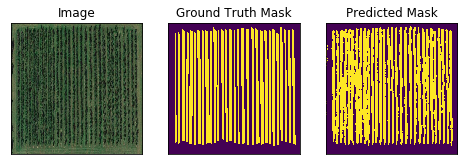

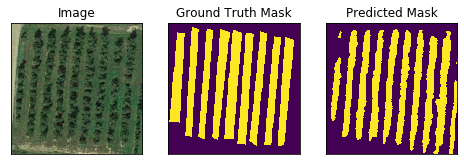

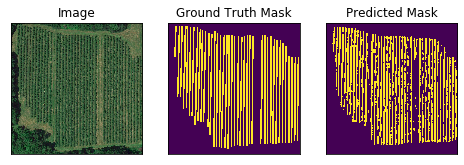

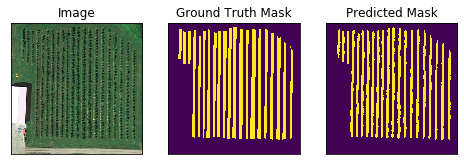

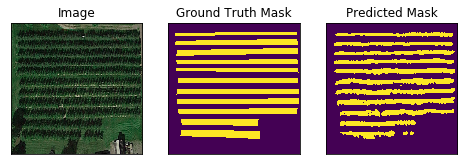

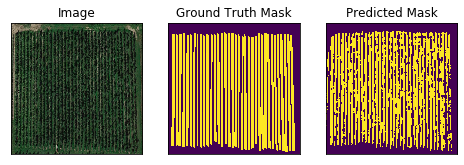

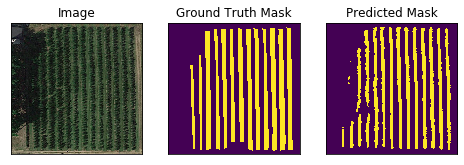

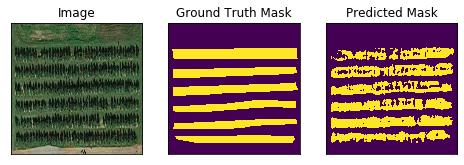

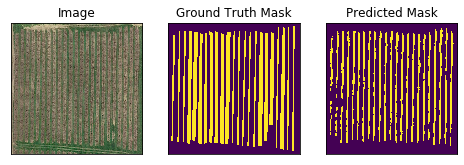

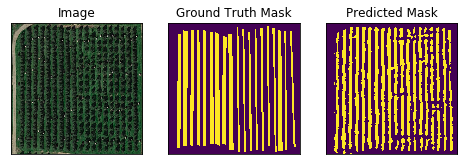

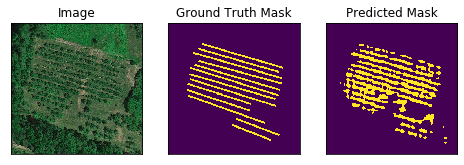

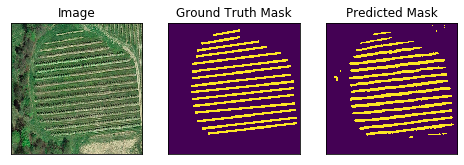

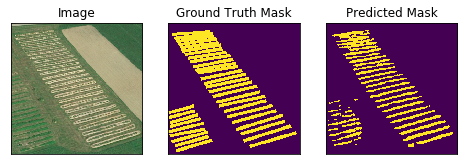

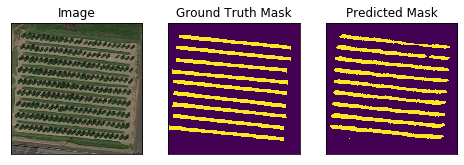

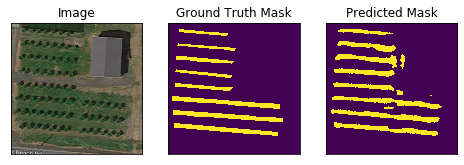

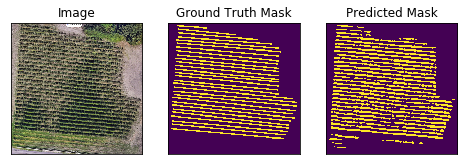

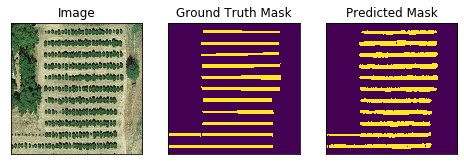

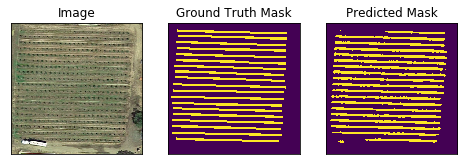

In [0]:
sig = nn.Sigmoid()
with torch.no_grad():
    mymodel.eval()
    mymodel.to(device)
    for i in range(len(val_dataset)):
        image, gt_mask = val_dataset[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = mymodel(x_tensor)
        pr_mask = pr_mask.squeeze().cpu()#.round()
        pr_mask = sig(pr_mask).round()
        visualize(image=image,ground_truth_mask=gt_mask,predicted_mask=pr_mask)
       

In [0]:
##merge lines that are near to each other based on distance
def merge_lines(lines):
    clusters =  []
    idx = []
    total_lines = len(lines)
    if total_lines < 30:
        distance_threshold = 20
    elif total_lines <75:
        distance_threshold = 15
    elif total_lines<120:
        distance_threshold = 10
    else:
        distance_threshold = 7
    for i,line in enumerate(lines):
        x1,y1,x2,y2 = line
    if [x1,y1,x2,y2] in idx:
        continue
    slope = (y2-y1)/(x2-x1+0.001)
    intercept = ((y2+y1) - slope *(x2+x1))/2
    a = -slope
    b = 1
    c = -intercept
    d = np.sqrt(a**2+b**2)
    cluster = [line]
    for d_line in lines[i+1:]:
        x,y,xo,yo= d_line
        mid_x = (x+xo)/2
        mid_y = (y+yo)/2
        distance = np.abs(a*mid_x+b*mid_y+c)/d
        if distance < distance_threshold:
            cluster.append(d_line)
            idx.append(d_line.tolist())
    clusters.append(np.array(cluster))
    merged_lines = [np.mean(cluster, axis=0) for cluster in clusters]
    return merged_lines

In [0]:
def draw_lines(image,mask):
    mask = mask*255
    mask = cv2.GaussianBlur(mask,(5,5),1)
    mask = cv2.Canny(mask.astype(np.uint8),80,255)
    lines = cv2.HoughLinesP(mask,1,np.pi / 180,threshold=50,
                        minLineLength=50,maxLineGap=250)
    lines = np.squeeze(lines, axis=1)
    m_lines = merge_lines(lines)
    for line in m_lines:
        x1, y1, x2, y2 = line.astype(int)
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    return image

In [0]:
def predict(model, image_location,op_image_name, device='cpu'):
    sig = nn.Sigmoid()
    image = cv2.imread(image_location)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    x,y = image.shape[:2]
    rs_image = cv2.resize(image,(384,384))
    ip_image = rs_image/255
    ip_image = ip_image.transpose((2,0,1))
    ip_image = torch.from_numpy(ip_image).float()
    with torch.no_grad():
        model.eval()
        model.to(device)
        x_tensor = ip_image.to(device).unsqueeze(0)
        pr_mask = model(x_tensor)
        pr_mask = pr_mask.squeeze().cpu()
        pr_mask = sig(pr_mask).numpy()
      
    op_image = draw_lines(np.copy(rs_image),pr_mask)
    pr_mask =  cv2.resize(pr_mask,(y,x))
    op_image = cv2.resize(op_image,(y,x))
    visualize(image=image,mask=pr_mask,rows=op_image)
    chk = cv2.imwrite(op_image_name,cv2.cvtColor(op_image,cv2.COLOR_RGB2BGR))
    if chk:
        print('saved to '+ op_image_name)


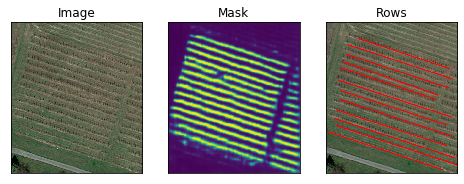

saved to op_img_004.png
--------------------------------------------------------------------------------


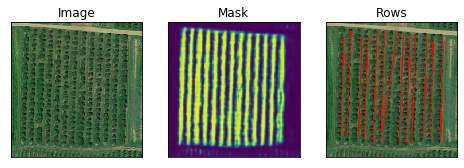

saved to op_img_021.png
--------------------------------------------------------------------------------


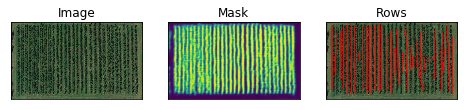

saved to op_img_027.png
--------------------------------------------------------------------------------


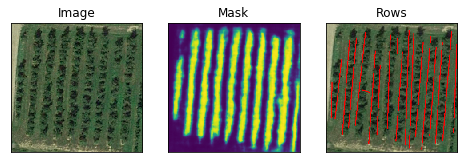

saved to op_img_031.png
--------------------------------------------------------------------------------


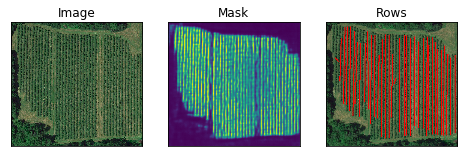

saved to op_img_040.png
--------------------------------------------------------------------------------


In [0]:
##checking line generation in val_data set
for i in range(5):
    image_location = val_dir+val_files[i]
    op_image_name = 'op_'+image_location.split('/')[-1]
    mask = predict(mymodel,image_location,op_image_name,device)
    print('--'*40)


In [0]:
##Images outside validation data set

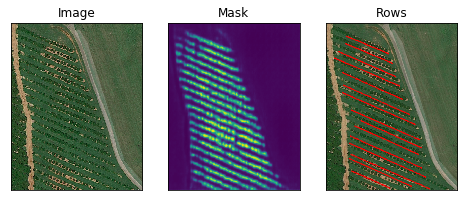

saved to op_img_145.png


In [0]:
image_location = 'dataset/Image/img_145.png'#val_dir+'img_021.png'
op_image_name = 'op_'+image_location.split('/')[-1]
mask = predict(mymodel,image_location,op_image_name,device)

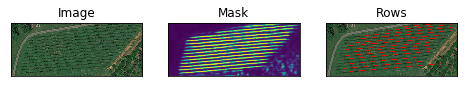

saved to op_img_146.png


In [0]:
image_location ='dataset/Image/img_146.png'#val_dir+'img_021.png'
op_image_name = 'op_'+image_location.split('/')[-1]
mask = predict(mymodel,image_location,op_image_name,device)

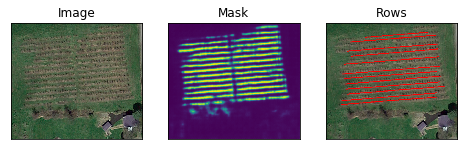

saved to op_img_150.png


In [0]:
image_location = 'dataset/Image/img_150.png'
op_image_name = 'op_'+image_location.split('/')[-1]
mask = predict(mymodel,image_location,op_image_name,device)

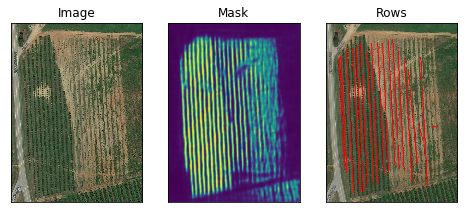

saved to op_img_147.png


In [0]:
image_location = 'dataset/Image/img_147.png'
op_image_name = 'op_'+image_location.split('/')[-1]
mask = predict(mymodel,image_location,op_image_name,device)

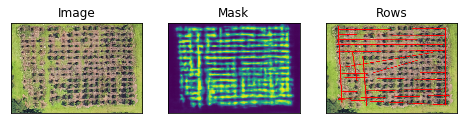

saved to op_img_148.png


In [0]:
image_location = 'dataset/Image/img_148.png'
op_image_name = 'op_'+image_location.split('/')[-1]
mask = predict(mymodel,image_location,op_image_name,device)